## Porject 2 - Advanced Line Finding

#### The goals / steps of this project are the following:

- Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
- Apply a distortion correction to raw images.
- Use color transforms, gradients, etc., to create a thresholded binary image.
- Apply a perspective transform to rectify binary image ("birds-eye view").
- Detect lane pixels and fit to find the lane boundary.
- Determine the curvature of the lane and vehicle position with respect to center.
- Warp the detected lane boundaries back onto the original image.
- Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

The images for camera calibration are stored in the folder called camera_cal. The images in test_images are for testing your pipeline on single frames. If you want to extract more test images from the videos, you can simply use an image writing method like cv2.imwrite(), i.e., you can read the video in frame by frame as usual, and for frames you want to save for later you can write to an image file.

To help the reviewer examine your work, please save examples of the output from each stage of your pipeline in the folder called output_images, and include a description in your writeup for the project of what each image shows. The video called project_video.mp4 is the video your pipeline should work well on.

The challenge_video.mp4 video is an extra (and optional) challenge for you if you want to test your pipeline under somewhat trickier conditions. The harder_challenge.mp4 video is another optional challenge and is brutal!

If you're feeling ambitious (again, totally optional though), don't stop there! We encourage you to go out and take video of your own, calibrate your camera and show us how you would implement this project from scratch!

In [33]:
# import libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import glob

### Build a Lane Finding Pipeline

In [34]:
test_images = glob.glob('test_images/*.jpg')
calibration_images = glob.glob('camera_cal/*.jpg')

print("Number of test images: ", len(test_images))
print("Number of calibration images: ", len(calibration_images))


Number of test images:  8
Number of calibration images:  20


### Camera calibration and perspective transformation utils

Number of image points collected:  17
Image(s) skipped during calibration:  ['camera_cal/calibration5.jpg', 'camera_cal/calibration4.jpg', 'camera_cal/calibration1.jpg']


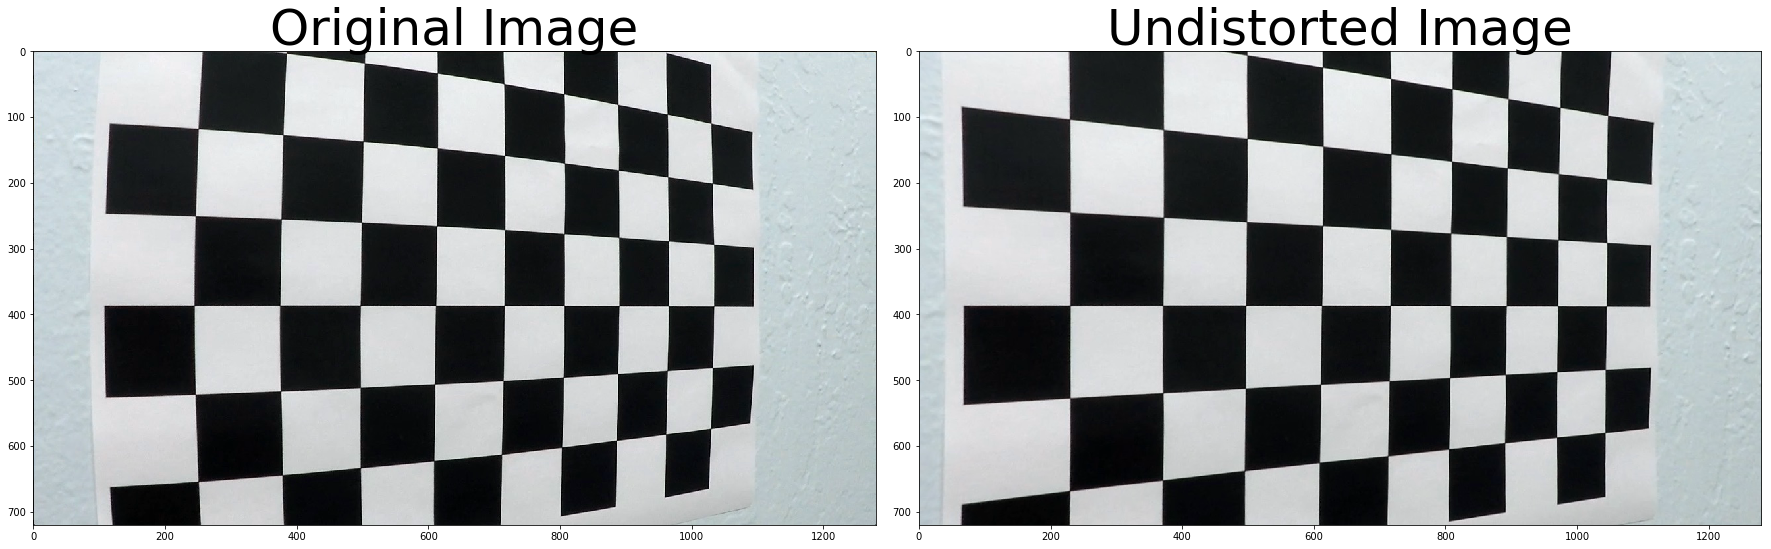

In [35]:
class CameraClibration:   
    def __init__(self, nx, ny, verbose = False):
        self.object_points = []
        self.image_points = []
        self.nx = nx
        self.ny = ny
        
        self.termination_criteria = criteria
        self.verbose = verbose
        
        self.camera_matrix = None
        self.distortion_coefficient = None
        self.rvecs = None
        self.tvecs = None
        
        self.skipped_images = []
        
        # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
        self._objp = np.zeros((ny*nx,3), np.float32)
        self._objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
    
    def process_images(self, calibration_images, criteria, win_size=(11, 11), zero_zone=(-1,-1)):
        for image in calibration_images:
            img = cv2.imread(image)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Find the chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

            # If found, draw corners
            if ret == True:
                self.object_points.append(self._objp)
                
                # refines the corner locations
                corners2 = cv2.cornerSubPix(gray, corners, win_size, zero_zone, criteria)
                self.image_points.append(corners2)
            else:
                self.skipped_images.append(image)
                
    
        print("Number of image points collected: ", len(self.image_points))
        print("Image(s) skipped during calibration: ", self.skipped_images)
        

    def cal_undistort(self, img):
        if len(self.image_points) != 0: 
            # Use cv2.calibrateCamera() and cv2.undistort()
            ret, self.camera_matrix, self.distortion_coefficient, self.rvecs, self.tvecs = cv2.calibrateCamera(self.object_points, self.image_points, img.shape[1::-1], None, None)
            undist = cv2.undistort(img, self.camera_matrix, self.distortion_coefficient, None, self.camera_matrix)
            if self.verbose:
                f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
                f.tight_layout()
                ax1.imshow(img)
                ax1.set_title('Original Image', fontsize=50)
                ax2.imshow(undist)
                ax2.set_title('Undistorted Image', fontsize=50)
                plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        else:
            raise ValueError("Image points not availbale")
        return undist
        

# prepare object points
nx = 9
ny = 6

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

calibration_utils = CameraClibration(nx, ny, verbose=True)
calibration_utils.process_images(calibration_images, criteria)

showcase_img = cv2.imread(calibration_utils.skipped_images[0])
undistorted = calibration_utils.cal_undistort(showcase_img)



### Basic line finding utils

In [36]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, mag_thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:, :, 2]
    if orient == 'x':
        sobel = cv2.Sobel(hls, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(hls, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))

    binary = np.zeros_like(scaled_sobel)
    binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1

    return binary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:, :, 2]
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(hls, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(hls, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:, :, 2]
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(hls, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(hls, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output
            
def corners_unwarp(img, undist, src, dst):
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undist, M, img_size)

    return warped

### Line fitting

In [37]:
def find_lane_pixels(binary_warped, nwindows=9, margin=100, minpix=50):
    # HYPERPARAMETERS
    # nwindows: Choose the number of sliding windows
    # margin: Set the width of the windows +/- margin
    # minpix: Set minimum number of pixels found to recenter window

    binary_warped = binary_warped.astype('uint8')
    # Take a histogram of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack([binary_warped, binary_warped, binary_warped])
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 3) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(255,0,0), 3) 

        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

def fit_polynomial(binary_warped, test=False):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped, nwindows=9, margin=100, minpix=150)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 255, 0]

    if test:
        # Plots the left and right polynomials on the lane lines
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')

    return out_img, left_fitx, right_fitx, ploty, left_fit, right_fit
    
def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped, left_fit, right_fit, margin=100, test=False):
    # HYPERPARAMETER
    # margin: Choose the width of the margin around the previous polynomial to search

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 255, 0]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin,  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    if test:
        # Plot the polynomial lines onto the image
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        ## End visualization steps ##
    
    return result

def search_around_poly_no_vis(binary_warped, left_fit, right_fit, margin=100, test=False):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    try:
        new_left_fit = np.polyfit(lefty, leftx, 2)
    except:
        print("Error searching from previous left lane")
        new_left_fit = left_fit
    try:
        new_right_fit = np.polyfit(righty, rightx, 2)
    except:
        print("Error searching from previous right lane")
        new_right_fit = right_fit
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    return new_left_fit, new_right_fit, ploty
    

### Testing with images

In [54]:
# just rgb
image = mpimg.imread('test_images/test3.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

Lanes are more visible in S channel of HLS and V of HSV compared to other channels.


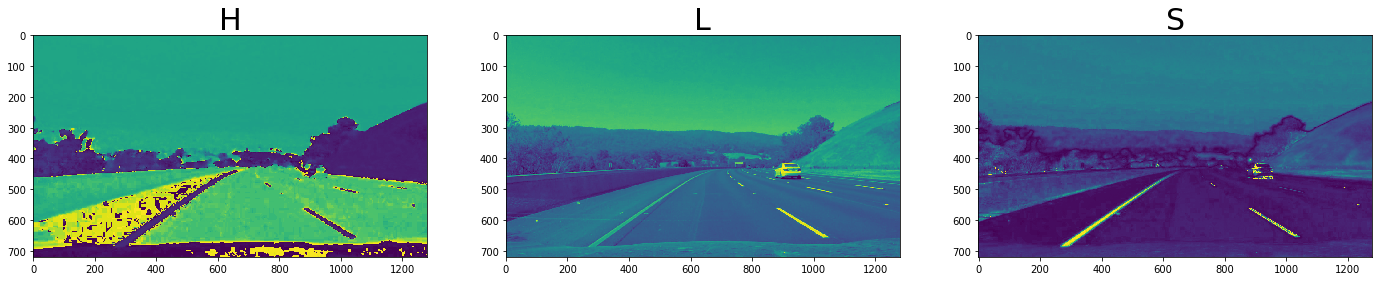

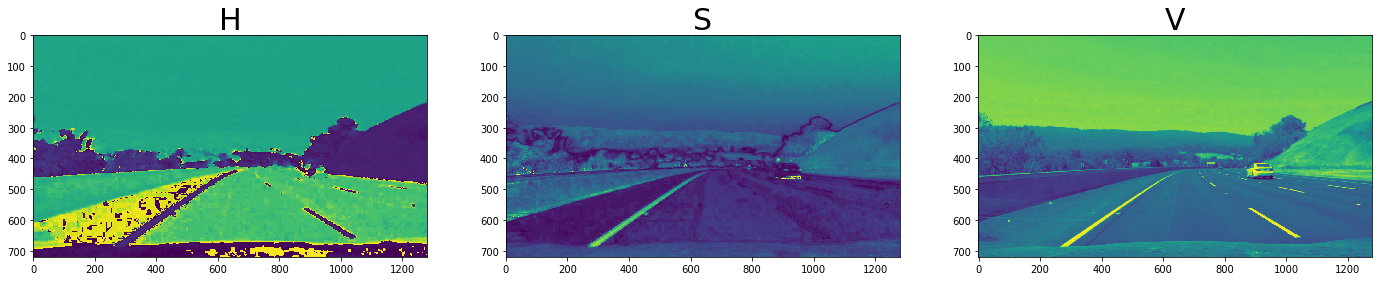

In [39]:
# covert to hls
hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
h_hls = hls[:, :, 0]
l_hls = hls[:, :, 1]
s_hls = hls[:, :, 2]
plt.figure()
_, (c1, c2, c3) = plt.subplots(1, 3, figsize=(24, 9))
c1.imshow(h_hls)
c1.set_title('H', fontsize=30)
c2.imshow(l_hls)
c2.set_title('L', fontsize=30)
c3.imshow(s_hls)
c3.set_title('S', fontsize=30)

# covert to hsv
hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
h_hsv = hsv[:, :, 0]
s_hsv = hsv[:, :, 1]
v_hsv = hsv[:, :, 2]
plt.figure()
_, (c4, c5, c6) = plt.subplots(1, 3, figsize=(24, 9))
c4.imshow(h_hsv)
c4.set_title('H', fontsize=30)
c5.imshow(s_hsv)
c5.set_title('S', fontsize=30)
c6.imshow(v_hsv)
c6.set_title('V', fontsize=30)

print("Lanes are more visible in S channel of HLS and V of HSV compared to other channels.")

Text(0.5,1,'Color combined')

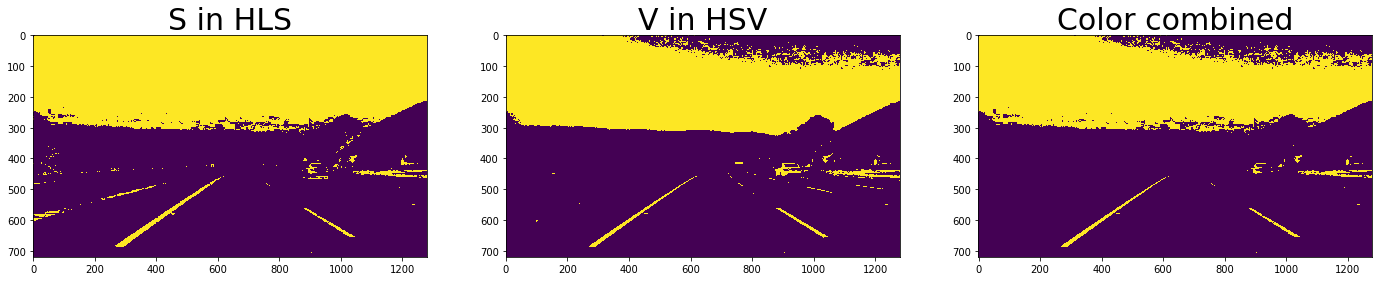

In [40]:
# HLS
s_hls_thresh = np.zeros_like(s_hls)
s_hls_thresh[(s_hls >= 90) & (s_hls <= 255)] = 1
fig, (a1, a2, a3) = plt.subplots(1, 3, figsize=(24, 9))
a1.set_title('S in HLS', fontsize=30)
a1.imshow(s_hls_thresh)

# HSV
v_hsv_thresh = np.zeros_like(v_hsv)
v_hsv_thresh[(v_hsv >= 190) & (v_hsv <= 255)] = 1
a2.set_title('V in HSV', fontsize=30)
a2.imshow(v_hsv_thresh)

# color combined
color_combined = np.zeros_like(s_hls)
color_combined[(s_hls_thresh == 1) & (v_hsv_thresh == 1)] = 1
a3.imshow(color_combined)
a3.set_title('Color combined', fontsize=30)

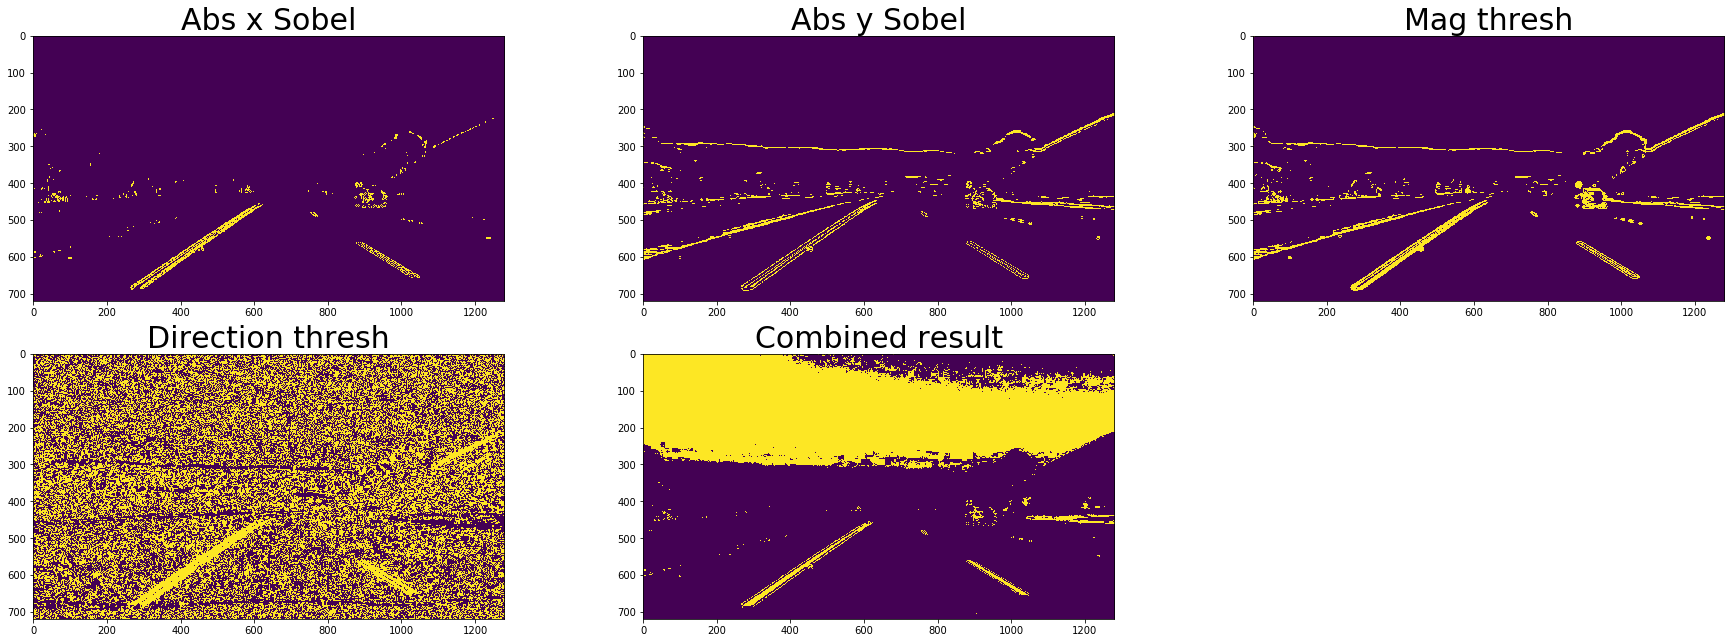

In [41]:
# gradient
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=15, mag_thresh=(30, 100))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=15, mag_thresh=(30, 100))
mag_binary = mag_thresh(image, sobel_kernel=15, mag_thresh=(30, 170))
dir_binary = dir_thresh(image, sobel_kernel=15, thresh=(0.5, 1.3))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1) & (mag_binary == 1) & (dir_binary == 1)) | (color_combined == 1)] = 1

# display
f, (ax1, ax2) = plt.subplots(2, 3, figsize=(24, 9))
ax1[0].imshow(gradx)
ax1[0].set_title('Abs x Sobel', fontsize=30)
ax1[1].imshow(grady)
ax1[1].set_title('Abs y Sobel', fontsize=30)
ax1[2].imshow(mag_binary)
ax1[2].set_title('Mag thresh', fontsize=30)
ax2[0].imshow(dir_binary)
ax2[0].set_title('Direction thresh', fontsize=30)
ax2[1].imshow(combined)
ax2[1].set_title('Combined result', fontsize=30)
f.delaxes(ax2[2])
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [42]:
# util functions
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

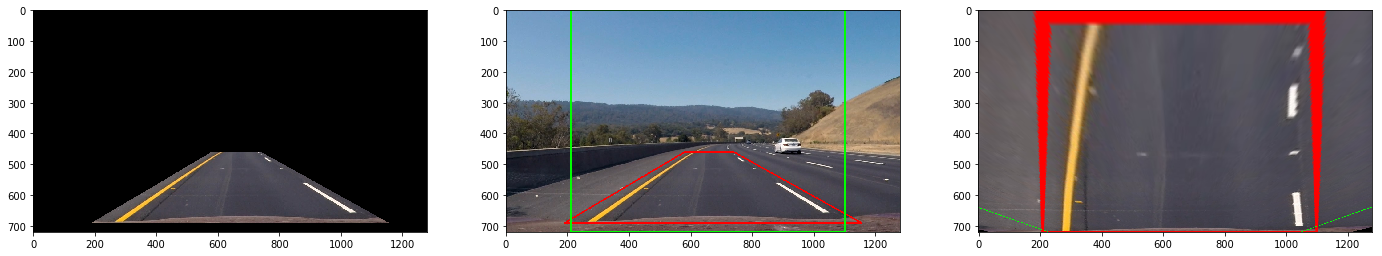

In [43]:
# apply region of interest
(x, y) = combined.shape
lane_points = np.array([[(190, 690), (580, 460), (740, 460), (1155, 690)]], dtype=np.int32)
warped_points = np.array([[(210, x-1), (210, 0), (1100, 0), (1100, x-1)]], dtype=np.int32)

input_roi = region_of_interest(image.copy(), lane_points)
output = cv2.polylines(image.copy(), lane_points, True, (255, 0, 0), 3)
transform_roi = cv2.polylines(output, warped_points, True, (0, 255, 0), 3)

warped = corners_unwarp(image.copy(), transform_roi, lane_points.astype('float32'), warped_points.astype('float32'))

fig, (a1, a2, a3) = plt.subplots(1, 3, figsize=(24, 9))
a1.imshow(input_roi)
a2.imshow(transform_roi)
a3.imshow(warped)

In [44]:
# process one frame
def process_image(image): 
    calibration_utils.verbose = False
    image = calibration_utils.cal_undistort(image)
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_hls = hls[:, :, 2]
    s_hls_thresh = np.zeros_like(s_hls)
    s_hls_thresh[(s_hls >= 120) & (s_hls <= 255)] = 1
    
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    v_hsv = hsv[:, :, 2]
    v_hsv_thresh = np.zeros_like(v_hsv)
    v_hsv_thresh[(v_hsv >= 190) & (v_hsv <= 255)] = 1
    
    color_combined = np.zeros_like(s_hls)
    color_combined[(s_hls_thresh == 1) & (v_hsv_thresh == 1)] = 1

    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=15, mag_thresh=(30, 100))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=15, mag_thresh=(30, 100))
    mag_binary = mag_thresh(image, sobel_kernel=15, mag_thresh=(30, 170))
    dir_binary = dir_thresh(image, sobel_kernel=15, thresh=(0.5, 1.3))

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1) & (mag_binary == 1) & (dir_binary == 1)) | (color_combined == 1)] = 1
        
    (x, y) = combined.shape
    lane_points = np.array([[(150, x), (580, 450), (740, 450), (1150, x)]], dtype=np.int32)
    warped_points = np.array([[(200, x), (200, 0), (1080, 0), (1080, x)]], dtype=np.int32)

    input_roi = region_of_interest(combined, lane_points)
    warped = corners_unwarp(combined, input_roi, lane_points.astype('float32'), warped_points.astype('float32'))
    
    for i in range(warped.shape[0]):
        for j in range(warped.shape[1]):
            if warped[i][j] != 0:
                warped[i][j] = 255
                
    return warped

Text(0.5,1,'Undistorted image')

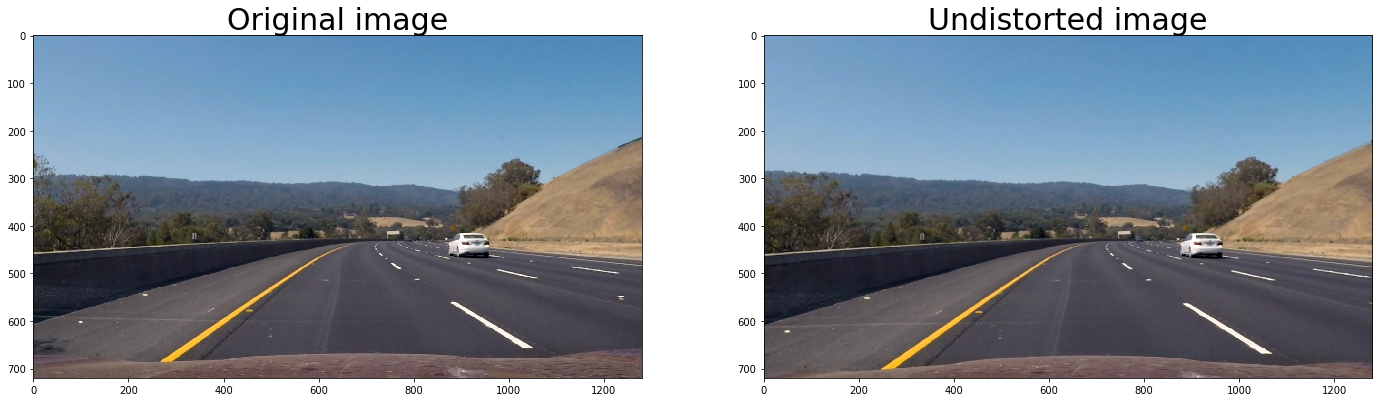

In [57]:
calibration_utils.verbose = False
undistorted = calibration_utils.cal_undistort(image)
fig, (a1, a2) = plt.subplots(1, 2, figsize=(24, 9))
a1.imshow(image)
a1.set_title('Original image', fontsize=30)
a2.imshow(undistorted)
a2.set_title('Undistorted image', fontsize=30)

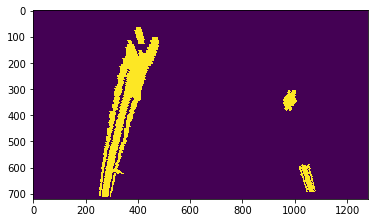

In [45]:
processed = process_image(image)
plt.figure()
plt.imshow(processed)

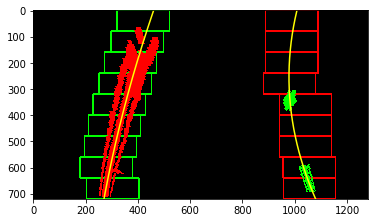

In [46]:
# apply lane finding
out_img, left_fitx, right_fitx, ploty, left_fit, right_fit = fit_polynomial(processed, test=True)
plt.imshow(out_img)

In [47]:
# measure curvature
def measure_curvature_real(left_fit_cr, right_fit_cr, ploty):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

left_curverad, right_curverad = measure_curvature_real(left_fit, right_fit, ploty)
print(left_curverad, 'm', right_curverad, 'm')

5353.84757597 m 1137.71790482 m


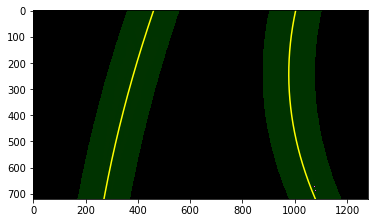

In [48]:
# search from the previous
left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])
result = search_around_poly(processed, left_fit, right_fit, test=True)
plt.imshow(result)

### Testing with videos

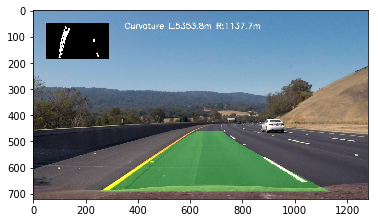

In [49]:
def embed_image(img1, img2, size=(240,135), offset=(50,50)):
    '''
    embeds a scaled image into another image
    '''
    output = np.copy(img1)
    # scale second image
    scaled = cv2.resize(img2,(size[0],size[1])) 
    if len(img2.shape) == 2:
        scaled = np.dstack((scaled, scaled, scaled))
    # embed image
    output[offset[1]:offset[1]+scaled.shape[0], offset[0]:offset[0]+scaled.shape[1]] = scaled
    return output

def draw_lanes(img, left_fit, right_fit, M_inv):
    '''
    draw lane lines
    '''
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create an image to draw the lines on
    color_warp = np.zeros_like(img)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    img_size = (color_warp.shape[1], color_warp.shape[0])
    lane_warp = cv2.warpPerspective(color_warp, M_inv, img_size)
    return lane_warp

def _get_text(curvature_m):
    return 'Curvature L:{:.1f}m R:{:.1f}m'.format(curvature_m[0], curvature_m[1])
#         , abs(offset_m)
#             'left' if offset_m >= 0 else 'right')

def draw_text(img, curvature_m): 
    cv2.putText(img, _get_text(curvature_m),
                    (350,70), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA)

# def eval_point_at_line(y, line):
#     return line[0]*(y**2) + line[1]*y + line[2] 

# def offset(y, width, xm, left_line, right_line):
#     left_x = eval_point_at_line(y, left_line)
#     right_x = eval_point_at_line(y, right_line)
#     return (((left_x+right_x)/2)-(width/2))*xm

M_inv = cv2.getPerspectiveTransform(warped_points.astype('float32'), lane_points.astype('float32'))
left_fit_g = None
right_fit_g = None
        
def f(img, test=False):
    global left_fit_g, right_fit_g
    warped = process_image(img)
    if left_fit_g == None and right_fit_g == None:
        out_img, left_fitx, right_fitx, ploty, left_fit, right_fit = fit_polynomial(warped)
    if (not test) and left_fit_g != None and right_fit_g != None: 
        left_fit, right_fit, ploty = search_around_poly_no_vis(warped, left_fit_g, right_fit_g)
    left_fit_g = left_fit
    right_fit_g = right_fit
    leftc, rightc = measure_curvature_real(left_fit_g, right_fit_g, ploty)
    draw_text(img, (leftc, rightc))
    lane_image = draw_lanes(img, left_fit_g, right_fit_g, M_inv)
    with_wieght = cv2.addWeighted(img, 1, lane_image, 0.3, 0)
    out = embed_image(with_wieght, warped)
    return out

test = f(image, test=True)
plt.imshow(test)

In [50]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

clip = VideoFileClip("project_video.mp4")
output = clip.fl_image(f)
output.write_videofile('process_pipline_output.mp4', audio=False)

[MoviePy] >>>> Building video process_pipline_output.mp4
[MoviePy] Writing video process_pipline_output.mp4




  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:01<33:57,  1.62s/it]

  0%|          | 2/1261 [00:03<34:01,  1.62s/it]

  0%|          | 3/1261 [00:04<33:57,  1.62s/it]

  0%|          | 4/1261 [00:06<33:55,  1.62s/it]

  0%|          | 5/1261 [00:08<34:48,  1.66s/it]

  0%|          | 6/1261 [00:09<34:27,  1.65s/it]

  1%|          | 7/1261 [00:11<34:14,  1.64s/it]

  1%|          | 8/1261 [00:13<33:58,  1.63s/it]

  1%|          | 9/1261 [00:14<33:48,  1.62s/it]

  1%|          | 10/1261 [00:16<33:40,  1.62s/it]

  1%|          | 11/1261 [00:17<33:34,  1.61s/it]

  1%|          | 12/1261 [00:19<33:28,  1.61s/it]

  1%|          | 13/1261 [00:21<33:28,  1.61s/it]

  1%|          | 14/1261 [00:22<33:24,  1.61s/it]

  1%|          | 15/1261 [00:24<33:20,  1.61s/it]

  1%|▏         | 16/1261 [00:25<33:19,  1.61s/it]

  1%|▏         | 17/1261 [00:27<33:14,  1.60s/it]

  1%|▏         | 18/1261 [00:29<33:16,  1.61s/it]

  2%|▏         | 19/1261 [00:30<33:16,  1.61s/i

 11%|█▏        | 143/1261 [03:59<31:33,  1.69s/it]

 11%|█▏        | 144/1261 [04:01<31:20,  1.68s/it]

 11%|█▏        | 145/1261 [04:03<31:28,  1.69s/it]

 12%|█▏        | 146/1261 [04:05<31:18,  1.68s/it]

 12%|█▏        | 147/1261 [04:06<31:28,  1.70s/it]

 12%|█▏        | 148/1261 [04:08<32:11,  1.74s/it]

 12%|█▏        | 149/1261 [04:10<32:04,  1.73s/it]

 12%|█▏        | 150/1261 [04:11<31:44,  1.71s/it]

 12%|█▏        | 151/1261 [04:13<31:40,  1.71s/it]

 12%|█▏        | 152/1261 [04:15<31:26,  1.70s/it]

 12%|█▏        | 153/1261 [04:17<31:24,  1.70s/it]

 12%|█▏        | 154/1261 [04:18<31:10,  1.69s/it]

 12%|█▏        | 155/1261 [04:20<31:11,  1.69s/it]

 12%|█▏        | 156/1261 [04:22<31:12,  1.69s/it]

 12%|█▏        | 157/1261 [04:23<30:59,  1.68s/it]

 13%|█▎        | 158/1261 [04:25<31:05,  1.69s/it]

 13%|█▎        | 159/1261 [04:27<30:57,  1.69s/it]

 13%|█▎        | 160/1261 [04:28<31:07,  1.70s/it]

 13%|█▎        | 161/1261 [04:30<31:12,  1.70s/it]

 13%|█▎     

 23%|██▎       | 284/1261 [07:59<27:48,  1.71s/it]

 23%|██▎       | 285/1261 [08:01<27:34,  1.69s/it]

 23%|██▎       | 286/1261 [08:03<27:32,  1.70s/it]

 23%|██▎       | 287/1261 [08:04<27:33,  1.70s/it]

 23%|██▎       | 288/1261 [08:06<27:24,  1.69s/it]

 23%|██▎       | 289/1261 [08:08<28:16,  1.75s/it]

 23%|██▎       | 290/1261 [08:10<27:56,  1.73s/it]

 23%|██▎       | 291/1261 [08:11<27:52,  1.72s/it]

 23%|██▎       | 292/1261 [08:13<27:35,  1.71s/it]

 23%|██▎       | 293/1261 [08:15<28:00,  1.74s/it]

 23%|██▎       | 294/1261 [08:17<27:44,  1.72s/it]

 23%|██▎       | 295/1261 [08:18<27:28,  1.71s/it]

 23%|██▎       | 296/1261 [08:20<27:33,  1.71s/it]

 24%|██▎       | 297/1261 [08:22<27:20,  1.70s/it]

 24%|██▎       | 298/1261 [08:23<27:28,  1.71s/it]

 24%|██▎       | 299/1261 [08:25<27:16,  1.70s/it]

 24%|██▍       | 300/1261 [08:27<27:23,  1.71s/it]

 24%|██▍       | 301/1261 [08:28<27:14,  1.70s/it]

 24%|██▍       | 302/1261 [08:30<27:18,  1.71s/it]

 24%|██▍    

 34%|███▎      | 425/1261 [12:01<23:50,  1.71s/it]

 34%|███▍      | 426/1261 [12:02<23:49,  1.71s/it]

 34%|███▍      | 427/1261 [12:04<23:45,  1.71s/it]

 34%|███▍      | 428/1261 [12:06<23:35,  1.70s/it]

 34%|███▍      | 429/1261 [12:08<23:48,  1.72s/it]

 34%|███▍      | 430/1261 [12:09<24:11,  1.75s/it]

 34%|███▍      | 431/1261 [12:11<24:00,  1.74s/it]

 34%|███▍      | 432/1261 [12:13<23:44,  1.72s/it]

 34%|███▍      | 433/1261 [12:14<23:46,  1.72s/it]

 34%|███▍      | 434/1261 [12:16<23:34,  1.71s/it]

 34%|███▍      | 435/1261 [12:18<23:38,  1.72s/it]

 35%|███▍      | 436/1261 [12:20<23:28,  1.71s/it]

 35%|███▍      | 437/1261 [12:21<23:25,  1.71s/it]

 35%|███▍      | 438/1261 [12:23<23:26,  1.71s/it]

 35%|███▍      | 439/1261 [12:25<23:14,  1.70s/it]

 35%|███▍      | 440/1261 [12:26<23:15,  1.70s/it]

 35%|███▍      | 441/1261 [12:28<23:07,  1.69s/it]

 35%|███▌      | 442/1261 [12:30<23:12,  1.70s/it]

 35%|███▌      | 443/1261 [12:31<23:03,  1.69s/it]

 35%|███▌   

 45%|████▍     | 566/1261 [16:02<19:52,  1.72s/it]

 45%|████▍     | 567/1261 [16:04<19:43,  1.70s/it]

 45%|████▌     | 568/1261 [16:06<19:47,  1.71s/it]

 45%|████▌     | 569/1261 [16:07<19:39,  1.70s/it]

 45%|████▌     | 570/1261 [16:09<20:25,  1.77s/it]

 45%|████▌     | 571/1261 [16:11<20:07,  1.75s/it]

 45%|████▌     | 572/1261 [16:13<20:02,  1.74s/it]

 45%|████▌     | 573/1261 [16:14<19:47,  1.73s/it]

 46%|████▌     | 574/1261 [16:16<19:46,  1.73s/it]

 46%|████▌     | 575/1261 [16:18<19:35,  1.71s/it]

 46%|████▌     | 576/1261 [16:20<19:35,  1.72s/it]

 46%|████▌     | 577/1261 [16:21<19:26,  1.71s/it]

 46%|████▌     | 578/1261 [16:23<19:27,  1.71s/it]

 46%|████▌     | 579/1261 [16:25<19:23,  1.71s/it]

 46%|████▌     | 580/1261 [16:26<19:20,  1.70s/it]

 46%|████▌     | 581/1261 [16:28<19:22,  1.71s/it]

 46%|████▌     | 582/1261 [16:30<19:14,  1.70s/it]

 46%|████▌     | 583/1261 [16:31<19:21,  1.71s/it]

 46%|████▋     | 584/1261 [16:33<19:24,  1.72s/it]

 46%|████▋  

Error searching from previous right lane




 48%|████▊     | 602/1261 [17:04<18:48,  1.71s/it]

Error searching from previous right lane




 48%|████▊     | 603/1261 [17:06<18:42,  1.71s/it]

Error searching from previous right lane




 48%|████▊     | 604/1261 [17:07<18:41,  1.71s/it]

 48%|████▊     | 605/1261 [17:09<19:12,  1.76s/it]

 48%|████▊     | 606/1261 [17:11<19:00,  1.74s/it]

 48%|████▊     | 607/1261 [17:13<18:56,  1.74s/it]

 48%|████▊     | 608/1261 [17:14<18:45,  1.72s/it]

 48%|████▊     | 609/1261 [17:16<18:44,  1.72s/it]

 48%|████▊     | 610/1261 [17:18<18:32,  1.71s/it]

 48%|████▊     | 611/1261 [17:20<18:36,  1.72s/it]

 49%|████▊     | 612/1261 [17:21<18:28,  1.71s/it]

 49%|████▊     | 613/1261 [17:23<18:40,  1.73s/it]

 49%|████▊     | 614/1261 [17:25<18:40,  1.73s/it]

 49%|████▉     | 615/1261 [17:26<18:27,  1.71s/it]

 49%|████▉     | 616/1261 [17:28<18:28,  1.72s/it]

 49%|████▉     | 617/1261 [17:30<18:18,  1.71s/it]

 49%|████▉     | 618/1261 [17:32<18:20,  1.71s/it]

 49%|████▉     | 619/1261 [17:33<18:20,  1.71s/it]

 49%|████▉     | 620/1261 [17:35<18:12,  1.70s/it]

 49%|████▉     | 621/1261 [17:37<18:17,  1.71s/it]

 49%|████▉     | 622/1261 [17:39<18:40,  1.75s/it]

 49%|████▉

 59%|█████▉    | 745/1261 [21:09<15:01,  1.75s/it]

 59%|█████▉    | 746/1261 [21:11<14:48,  1.73s/it]

 59%|█████▉    | 747/1261 [21:13<14:45,  1.72s/it]

 59%|█████▉    | 748/1261 [21:14<14:36,  1.71s/it]

 59%|█████▉    | 749/1261 [21:16<14:37,  1.71s/it]

 59%|█████▉    | 750/1261 [21:18<14:31,  1.71s/it]

 60%|█████▉    | 751/1261 [21:19<14:33,  1.71s/it]

 60%|█████▉    | 752/1261 [21:21<14:24,  1.70s/it]

 60%|█████▉    | 753/1261 [21:23<14:26,  1.71s/it]

 60%|█████▉    | 754/1261 [21:25<14:18,  1.69s/it]

 60%|█████▉    | 755/1261 [21:26<14:21,  1.70s/it]

 60%|█████▉    | 756/1261 [21:28<14:15,  1.69s/it]

 60%|██████    | 757/1261 [21:30<14:20,  1.71s/it]

 60%|██████    | 758/1261 [21:31<14:14,  1.70s/it]

 60%|██████    | 759/1261 [21:33<14:15,  1.71s/it]

 60%|██████    | 760/1261 [21:35<14:11,  1.70s/it]

 60%|██████    | 761/1261 [21:36<14:13,  1.71s/it]

 60%|██████    | 762/1261 [21:38<14:35,  1.75s/it]

 61%|██████    | 763/1261 [21:40<14:29,  1.75s/it]

 61%|██████ 

 70%|███████   | 886/1261 [25:11<10:51,  1.74s/it]

 70%|███████   | 887/1261 [25:13<10:52,  1.74s/it]

 70%|███████   | 888/1261 [25:14<10:46,  1.73s/it]

 70%|███████   | 889/1261 [25:16<10:39,  1.72s/it]

 71%|███████   | 890/1261 [25:18<10:42,  1.73s/it]

 71%|███████   | 891/1261 [25:19<10:38,  1.72s/it]

 71%|███████   | 892/1261 [25:21<10:36,  1.72s/it]

 71%|███████   | 893/1261 [25:23<10:34,  1.73s/it]

 71%|███████   | 894/1261 [25:25<10:29,  1.71s/it]

 71%|███████   | 895/1261 [25:26<10:28,  1.72s/it]

 71%|███████   | 896/1261 [25:28<10:23,  1.71s/it]

 71%|███████   | 897/1261 [25:30<10:23,  1.71s/it]

 71%|███████   | 898/1261 [25:31<10:21,  1.71s/it]

 71%|███████▏  | 899/1261 [25:33<10:19,  1.71s/it]

 71%|███████▏  | 900/1261 [25:35<10:15,  1.70s/it]

 71%|███████▏  | 901/1261 [25:37<10:17,  1.71s/it]

 72%|███████▏  | 902/1261 [25:38<10:29,  1.75s/it]

 72%|███████▏  | 903/1261 [25:40<10:24,  1.74s/it]

 72%|███████▏  | 904/1261 [25:42<10:15,  1.73s/it]

 72%|███████

 81%|████████▏ | 1026/1261 [29:11<06:55,  1.77s/it]

 81%|████████▏ | 1027/1261 [29:13<06:48,  1.74s/it]

 82%|████████▏ | 1028/1261 [29:15<06:44,  1.74s/it]

 82%|████████▏ | 1029/1261 [29:17<06:42,  1.73s/it]

 82%|████████▏ | 1030/1261 [29:18<06:40,  1.73s/it]

 82%|████████▏ | 1031/1261 [29:20<06:35,  1.72s/it]

 82%|████████▏ | 1032/1261 [29:22<06:34,  1.72s/it]

 82%|████████▏ | 1033/1261 [29:23<06:35,  1.73s/it]

 82%|████████▏ | 1034/1261 [29:25<06:33,  1.73s/it]

 82%|████████▏ | 1035/1261 [29:27<06:28,  1.72s/it]

 82%|████████▏ | 1036/1261 [29:29<06:26,  1.72s/it]

 82%|████████▏ | 1037/1261 [29:30<06:25,  1.72s/it]

 82%|████████▏ | 1038/1261 [29:32<06:22,  1.72s/it]

 82%|████████▏ | 1039/1261 [29:34<06:20,  1.71s/it]

 82%|████████▏ | 1040/1261 [29:35<06:18,  1.71s/it]

 83%|████████▎ | 1041/1261 [29:37<06:16,  1.71s/it]

 83%|████████▎ | 1042/1261 [29:39<06:27,  1.77s/it]

 83%|████████▎ | 1043/1261 [29:41<06:20,  1.74s/it]

 83%|████████▎ | 1044/1261 [29:42<06:13,  1.72

 92%|█████████▏| 1164/1261 [33:11<02:52,  1.78s/it]

 92%|█████████▏| 1165/1261 [33:13<02:48,  1.75s/it]

 92%|█████████▏| 1166/1261 [33:15<02:45,  1.75s/it]

 93%|█████████▎| 1167/1261 [33:16<02:42,  1.73s/it]

 93%|█████████▎| 1168/1261 [33:18<02:40,  1.73s/it]

 93%|█████████▎| 1169/1261 [33:20<02:38,  1.73s/it]

 93%|█████████▎| 1170/1261 [33:22<02:36,  1.72s/it]

 93%|█████████▎| 1171/1261 [33:23<02:35,  1.73s/it]

 93%|█████████▎| 1172/1261 [33:25<02:32,  1.72s/it]

 93%|█████████▎| 1173/1261 [33:27<02:32,  1.73s/it]

 93%|█████████▎| 1174/1261 [33:28<02:29,  1.72s/it]

 93%|█████████▎| 1175/1261 [33:30<02:28,  1.73s/it]

 93%|█████████▎| 1176/1261 [33:32<02:26,  1.72s/it]

 93%|█████████▎| 1177/1261 [33:34<02:25,  1.73s/it]

 93%|█████████▎| 1178/1261 [33:35<02:23,  1.72s/it]

 93%|█████████▎| 1179/1261 [33:37<02:21,  1.73s/it]

 94%|█████████▎| 1180/1261 [33:39<02:23,  1.77s/it]

 94%|█████████▎| 1181/1261 [33:41<02:20,  1.76s/it]

 94%|█████████▎| 1182/1261 [33:42<02:17,  1.74

[MoviePy] Done.
[MoviePy] >>>> Video ready: process_pipline_output.mp4 



In [52]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('process_pipline_output.mp4'))